# Numba implementation of greedy search

### Imports

In [74]:
from realkd.rules import RuleBoostingEstimator, XGBRuleEstimator, logistic_loss
from realkd.search import search_methods
from numba import njit, parallel_chunksize
import pandas as pd
import sortednp as snp
import doctest

from collections import defaultdict, deque
from sortedcontainers import SortedSet
from math import inf
from heapq import heappop, heappush
from numpy import array
from bitarray import bitarray
import collections.abc
from numba.typed import List
from math import inf
from numpy import arange, argsort, array, cumsum, exp, full_like, log2, stack, zeros, zeros_like
from pandas import qcut, Series
import time
from sklearn.base import BaseEstimator, clone

from realkd.search import Conjunction, Context, KeyValueProposition, Constraint
from bitarray.util import subset

from realkd.logic import Conjunction, Constraint, KeyValueProposition, TabulatedProposition

## Create test data

As test data we generate simple binary random matrices $R \in \{0, 1\}^{m \times n}$ with a fixed proportion of 1-entries ($\alpha=0.5$) for a range of $n$ and $m$ values.

In [23]:
import numpy as np
import pandas as pd

RNG = np.random.default_rng(seed=0)

In [24]:
def rand_array(size, alpha=0.2):
    n, k = size
    d = np.arange(n*k)
    RNG.shuffle(d)
    d = (d < alpha*len(d)).astype(int)
    return d.reshape(n, k)

In [71]:
# n = length of data
# m = width (columns) of data
ns = np.arange(50, 10051, 1000)
ms = np.arange(50, 501, 50)

alpha = 0.5

d = {}
for m in ms:
    for n in ns:
        X = rand_array((n, m), alpha=alpha)
        true_weights = RNG.random(m) * 10
        y = X @ true_weights + RNG.random(n)
        y = np.sign(y - y.mean())
        dfX = pd.DataFrame(data=X, index=None, columns=[f'x{i}' for i in range(X.shape[1])])
        dfy = pd.Series(data=y)
        d[(m, n)] = (dfX, dfy)

## Existing implementation

In [75]:
@njit
def intersect_sorted_arrays(A, B):
  """
  Returns the sorted intersection of A and B
  - Assumes A and B are sorted
  - Assumes A and B each have no duplicates
  """
  i = 0
  j = 0
  intersection = List()

  while i < len(A) and j < len(B):
      if A[i] == B[j]:
          intersection.append(A[i])
          i += 1
          j += 1
      elif A[i] < B[j]:
          i += 1
      else:
          j += 1
  return np.asarray(intersection)

@njit
def find_best_new_index(current_intent, current_extent, extents, initial_value, n, objective_function):
    best_i, best_ext = None, current_extent
    value = initial_value
    for i in range(n):
        for index in current_intent:
            if index == i:
                continue
        new_extent = intersect_sorted_arrays(current_extent, extents[i])
        new_value = objective_function(new_extent)
        if new_value > value:
            value = new_value
            best_ext = new_extent
            best_i = i
    return (best_i, best_ext, value)

@njit
def numba_run(extent, n, extents, objective_function):
    """
    Runs the configured search.

    :return: :class:`~realkd.logic.Conjunction` that (approximately) maximizes objective
    """
    intent = List([-1])
    value = objective_function(extent)
    while True:
        best_i, best_ext = None, extent
        # Find best i to add to intent
        for i in range(n):
            for index in intent:
                if index == i:
                    continue
            new_extent = intersect_sorted_arrays(extent, extents[i])
            new_value = objective_function(new_extent)
            if new_value > value:
                value = new_value
                best_ext = new_extent
                best_i = i
        if best_i is not None:
            # Update intent and try again
            intent.append(best_i)
            extent = best_ext
        else:
            # Intent can't get any better
            break
    return intent[1:]

class NumbaGreedySearch:
    def __init__(self, ctx, obj, bdn, verbose=False, **kwargs):
        """

        :param Context ctx: the context defining the search space
        :param callable obj: objective function
        :param callable bnd: bounding function satisfying that ``bnd(q) >= max{obj(r) for r in successors(q)}`` (for signature compatibility only, not currently used)
        :param int verbose: level of verbosity

        """
        self.ctx = ctx
        self.f = obj
        self.verbose = verbose

    def run(self):
        """
        Runs the configured search.

        :return: :class:`~realkd.logic.Conjunction` that (approximately) maximizes objective
        """
        initial_extent = np.array(self.ctx.extension([]))
        n = self.ctx.n
        extents = List(self.ctx.extents)

        intent = numba_run(initial_extent, self.ctx.n, extents, objective_function=self.f)

        return Conjunction(map(lambda i: self.ctx.attributes[i], intent))

def build_numba_obj_function(X, y):
    """
    This would be part of the objective e.g GradientBoostingObjective
    """
    # The following is only ONE example of this class of objective function, it would be different for
    # different X, y, losses, regs and predictions.
    loss = logistic_loss
    reg = 1.0
    predictions = zeros_like(y)
    g = array(loss.g(y, predictions))
    h = array(loss.h(y, predictions))
    r = g / h
    order = argsort(r)[::-1]
    g = g[order]
    h = h[order]
    n = y.shape[0]

    @njit
    def objective_function(ext):
        if len(ext) == 0:
            return -inf
        g_q = g[ext]
        h_q = h[ext]
        return g_q.sum() ** 2 / (2 * n * (reg + h_q.sum()))

    return objective_function


In [67]:
from realkd.search import GreedySearch

def run_search_numba(data, context):
    ctx, g, h, reg, obj_fn = context
    search = NumbaGreedySearch(ctx=ctx, obj=objective_function, bdn=None, g=g, h=h, reg=reg)
    search.run()

def run_search_base(data, context):
    ctx, g, h, reg, obj_fn = context
    search = GreedySearch(ctx=ctx, obj=obj_fn, bdn=None)
    search.run()

In [72]:
import warnings
warnings.filterwarnings("ignore")

t_numba = {}
t_base = {}

ms_to_plot = ms
ns_to_plot = ns

pre_made_ctx = {}

for m in ms_to_plot:
    data = d[(m, ns[0])]
    ctx = Context.from_df(data[0])
    obj_fn = build_numba_obj_function(data[0], data[1])
    pre_made_ctx[(m, ns[0])] = ctx, obj_fn

for n in ns_to_plot:
    data = d[(ms[0], n)]
    ctx = Context.from_df(data[0])
    obj_fn = build_numba_obj_function(data[0], data[1])
    pre_made_ctx[(ms[0], n)] = ctx, obj_fn


# Dry runs to compile numba code
run_search_numba(d[(ms[0], ns[0])], pre_made_ctx[(ms[0], ns[0])])
run_search_base(d[(ms[0], ns[0])], pre_made_ctx[(ms[0], ns[0])])

for m in ms_to_plot:
    t_numba[(m, ns[0])] = %timeit -o run_search_numba(d[(m, ns[0])], pre_made_ctx[(m, ns[0])])
    t_base[(m, ns[0])] = %timeit -o run_search_base(d[(m, ns[0])], pre_made_ctx[(m, ns[0])])

for n in ns_to_plot:
    t_numba[(ms[0], n)] = %timeit -o run_search_numba(d[(ms[0], n)], pre_made_ctx[(ms[0], n)])
    t_base[(ms[0], n)] = %timeit -o run_search_base(d[(ms[0], n)], pre_made_ctx[(ms[0], n)])

551 µs ± 25.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.52 ms ± 87.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.3 ms ± 48.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
4.39 ms ± 331 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.97 ms ± 33.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
6.2 ms ± 76.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.46 ms ± 26.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
8.46 ms ± 166 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.59 ms ± 33.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
7.84 ms ± 111 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.11 ms ± 23.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
9.71 ms ± 375 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.22 ms ± 63.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
14.8 ms ± 397 µs per loop (mean ± std. dev. of 7 runs, 100 loop

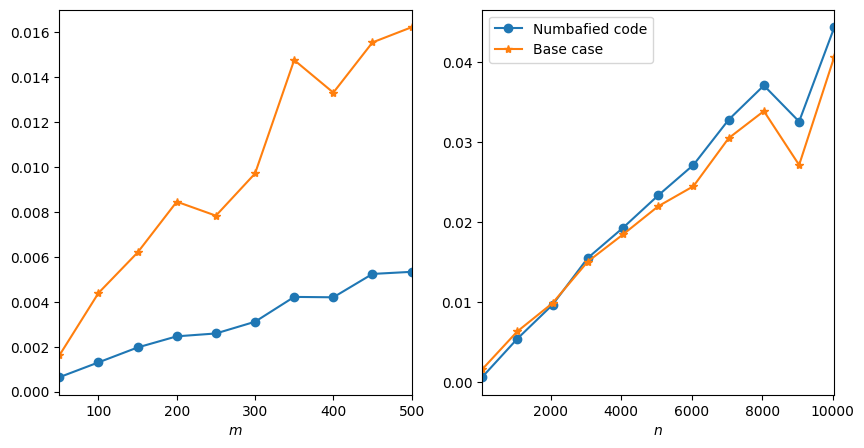

In [73]:
plt.subplots(1, 2, figsize=(10, 5))

t_numba_mean = [t_numba[(m, ns[0])].average for m in ms_to_plot]
t_numba_std = [t_numba[(m, ns[0])].stdev for m in ms_to_plot]
t_base_mean = [t_base[(m, ns[0])].average for m in ms_to_plot]
t_base_std = [t_base[(m, ns[0])].stdev for m in ms_to_plot]

plt.subplot(1, 2, 1)
plt.plot(ms_to_plot, t_numba_mean, marker='o')
plt.plot(ms_to_plot, t_base_mean, marker='*')
plt.xlim(ms_to_plot[0], ms_to_plot[-1])
plt.xlabel('$m$')

t_numba_mean = [t_numba[(ms[0], n)].average for n in ns_to_plot]
t_numba_std = [t_numba[(ms[0], n)].stdev for n in ns_to_plot]
t_base_mean = [t_base[(ms[0], n)].average for n in ns_to_plot]
t_base_std = [t_base[(ms[0], n)].stdev for n in ns_to_plot]

plt.subplot(1, 2, 2)
plt.plot(ns_to_plot, t_numba_mean, marker='o', label='Numbafied code')
plt.plot(ns_to_plot, t_base_mean, marker='*', label='Base case')
plt.xlim(ns_to_plot[0], ns_to_plot[-1])
plt.xlabel('$n$')
plt.legend()

plt.show()